# This code is to analysis the GPU performance of different power level

## here is the test code for the GPU power and performance tradeoff

Files already downloaded and verified


/home/zzq/miniconda3/envs/greenai/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zzq/miniconda3/envs/greenai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


功率上限已设置为 100 W
设置功率限制为 100W
功率限制 100W 完成，耗时 3.65 秒
Batch 97, Loss: 1.3597
功率上限已设置为 120 W
设置功率限制为 120W
功率限制 120W 完成，耗时 3.59 秒
Batch 97, Loss: 1.1656
功率上限已设置为 140 W
设置功率限制为 140W
功率限制 140W 完成，耗时 3.56 秒
Batch 97, Loss: 0.9344
功率上限已设置为 160 W
设置功率限制为 160W
功率限制 160W 完成，耗时 3.66 秒
Batch 97, Loss: 0.8153
功率上限已设置为 180 W
设置功率限制为 180W
功率限制 180W 完成，耗时 3.55 秒
Batch 97, Loss: 0.6500
功率上限已设置为 200 W
设置功率限制为 200W
功率限制 200W 完成，耗时 3.50 秒
Batch 97, Loss: 0.6012
功率上限已设置为 220 W
设置功率限制为 220W
功率限制 220W 完成，耗时 3.55 秒
Batch 97, Loss: 0.4711
功率上限已设置为 240 W
设置功率限制为 240W
功率限制 240W 完成，耗时 3.58 秒
Batch 97, Loss: 0.4512
功率上限已设置为 260 W
设置功率限制为 260W
功率限制 260W 完成，耗时 3.63 秒
Batch 97, Loss: 0.2379
功率上限已设置为 280 W
设置功率限制为 280W
功率限制 280W 完成，耗时 3.56 秒
Batch 97, Loss: 0.2322
功率上限已设置为 300 W
设置功率限制为 300W
功率限制 300W 完成，耗时 3.51 秒
Batch 97, Loss: 0.1831
功率上限已设置为 320 W
设置功率限制为 320W
功率限制 320W 完成，耗时 3.52 秒
Batch 97, Loss: 0.0852

性能测试结果：
    power_limit      time  avg_graphics_clock  avg_memory_clock
0           100  3.645549              

/home/zzq/miniconda3/envs/greenai/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/zzq/miniconda3/envs/greenai/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/zzq/miniconda3/envs/greenai/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/zzq/miniconda3/envs/greenai/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/zzq/miniconda3/envs/greenai/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyp

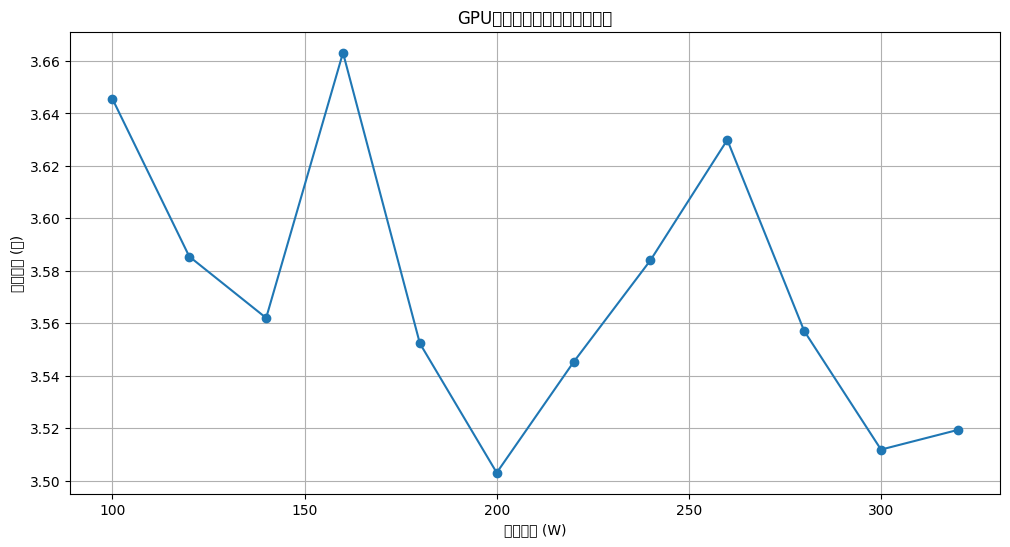

In [2]:
import subprocess
from time import time
import pynvml
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from torchvision import datasets, transforms

# 数据集转换（如归一化、数据增强等）
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # 假设单通道图像
])

# 加载 CIFAR-10 数据集
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# 初始化 PyTorch 模型、数据和优化器
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 初始化 ResNet18 模型
model = resnet18(pretrained=False).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
train_loader = DataLoader(dataset, batch_size=512, shuffle=True)

# 初始化 pynvml
pynvml.nvmlInit()
handle = pynvml.nvmlDeviceGetHandleByIndex(0)

# 定义功率限制范围
power_limits = range(100, 321, 20)
results = []

try:
    for power_limit in power_limits:
        # 设置功率限制
        subprocess.run(
            ["sudo", "/home/zzq/miniconda3/envs/greenai/bin/python", "set_power_limit.py", str(power_limit)],
            check=True
        )
        print(f"设置功率限制为 {power_limit}W")

        start_time = time()
        total_graphics_clock = 0
        total_memory_clock = 0
        total_iterations = 0

        # 训练模型
        model.train()
        for i, (inputs, labels) in enumerate(train_loader, 0):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_graphics_clock += pynvml.nvmlDeviceGetClockInfo(handle, pynvml.NVML_CLOCK_GRAPHICS)
            total_memory_clock += pynvml.nvmlDeviceGetClockInfo(handle, pynvml.NVML_CLOCK_MEM)
            total_iterations += 1

            # if i >= 100:  # 测试 100 个批次
            #     break

        duration = time() - start_time
        avg_graphics_clock = total_graphics_clock / total_iterations
        avg_memory_clock = total_memory_clock / total_iterations

        results.append({
            "power_limit": power_limit,
            "time": duration,
            "avg_graphics_clock": avg_graphics_clock,
            "avg_memory_clock": avg_memory_clock
        })

        print(f"功率限制 {power_limit}W 完成，耗时 {duration:.2f} 秒")
        print(f"Batch {i}, Loss: {loss.item():.4f}")

finally:
    pynvml.nvmlShutdown()

# 结果分析与可视化
results_df = pd.DataFrame(results)
print("\n性能测试结果：")
print(results_df)

plt.figure(figsize=(12, 6))
plt.plot(results_df['power_limit'], results_df['time'], marker='o')
plt.xlabel('功率限制 (W)')
plt.ylabel('训练时间 (秒)')
plt.title('GPU功率限制与训练时间的关系')
plt.grid(True)
plt.show()